[*********************100%***********************]  1 of 1 completed


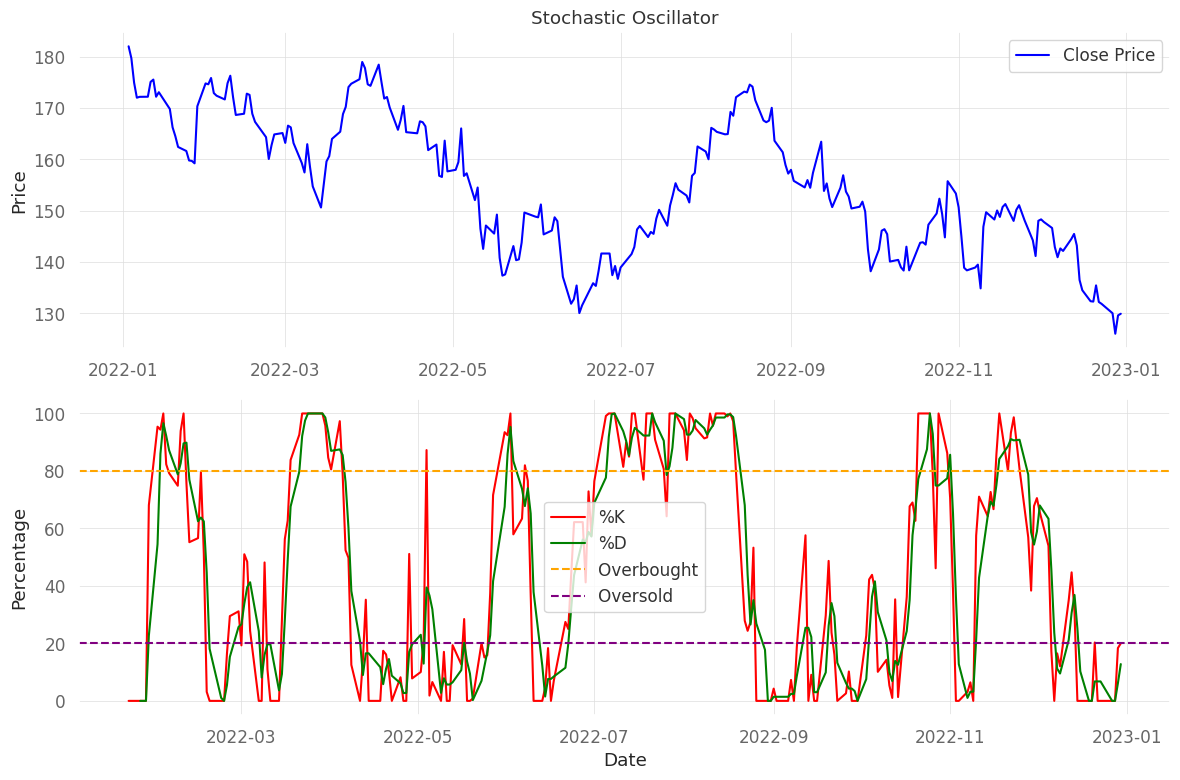

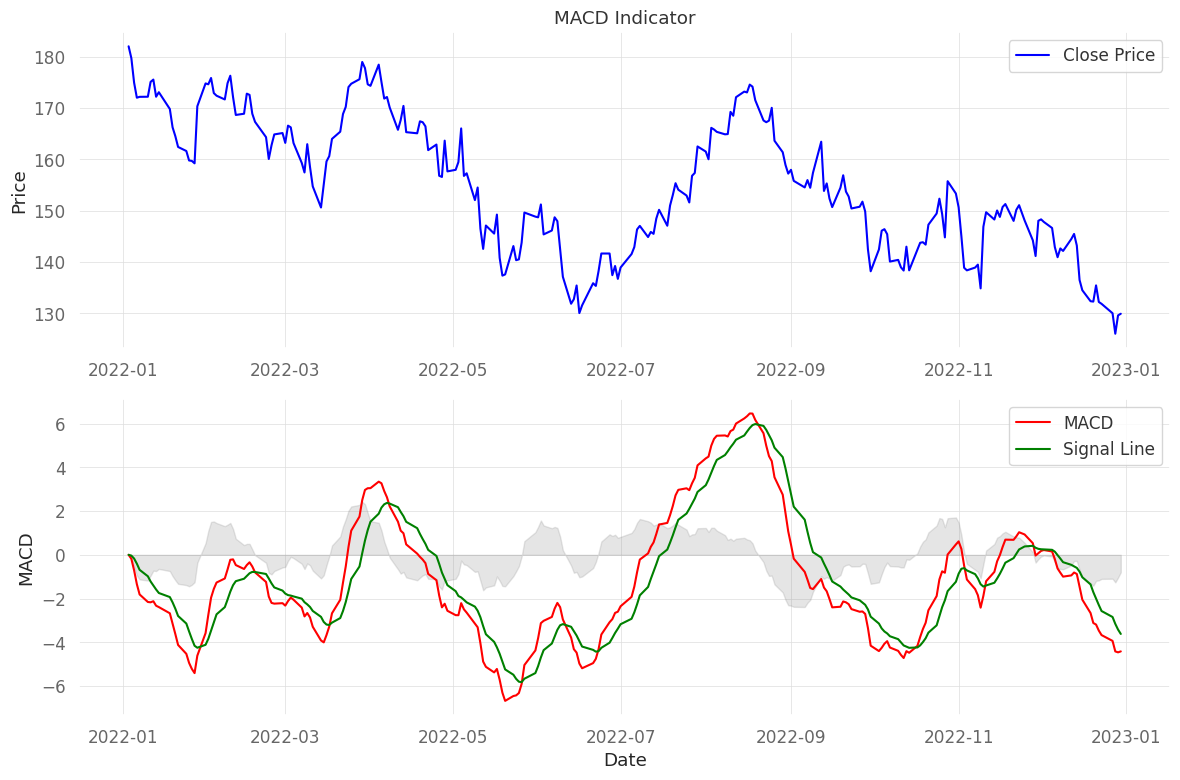

Total Profit: $0.00
Return: 0.00%
Performance Metrics:
Total Return: 1.00
Annualized Return: 0.00
Max Drawdown: 0.00%
Sharpe Ratio: 0.00


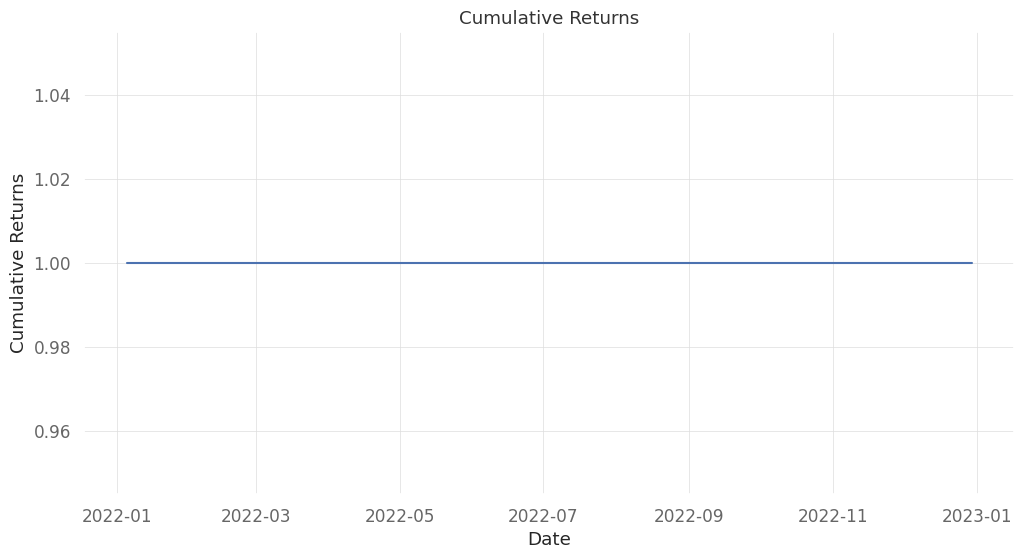

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_stochastic_oscillator(data, k_period, d_period):
    data['lowest_low'] = data['Close'].rolling(k_period).min()
    data['highest_high'] = data['Close'].rolling(k_period).max()
    data['%K'] = (data['Close'] - data['lowest_low']) / (data['highest_high'] - data['lowest_low']) * 100
    data['%D'] = data['%K'].rolling(d_period).mean()
    return data

def calculate_macd(data, ema_short, ema_long, signal_period):
    data['EMA_short'] = data['Close'].ewm(span=ema_short, adjust=False).mean()
    data['EMA_long'] = data['Close'].ewm(span=ema_long, adjust=False).mean()
    data['MACD'] = data['EMA_short'] - data['EMA_long']
    data['Signal_line'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
    return data

def plot_stochastic_oscillator(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(data['Close'], color='blue', label='Close Price')
    ax1.set_title('Stochastic Oscillator')
    ax1.set_ylabel('Price')
    ax1.legend()

    ax2.plot(data['%K'], color='red', label='%K')
    ax2.plot(data['%D'], color='green', label='%D')
    ax2.axhline(y=80, color='orange', linestyle='--', label='Overbought')
    ax2.axhline(y=20, color='purple', linestyle='--', label='Oversold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Percentage')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_macd(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(data['Close'], color='blue', label='Close Price')
    ax1.set_title('MACD Indicator')
    ax1.set_ylabel('Price')
    ax1.legend()

    ax2.plot(data['MACD'], color='red', label='MACD')
    ax2.plot(data['Signal_line'], color='green', label='Signal Line')
    ax2.fill_between(data.index, data['MACD']-data['Signal_line'], color='gray', alpha=0.2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def backtest_strategy(data, capital):
    position = None
    buy_price = 0
    returns = []
    for i in range(1, len(data)):
        if data['%K'][i] < 20 and data['%D'][i] < 20 and data['MACD'][i] > data['Signal_line'][i]:
            if position is None:
                position = 'long'
                buy_price = data['Close'][i]
                print(f"Buy at ${buy_price}")
        elif data['%K'][i] > 80 and data['%D'][i] > 80 and data['MACD'][i] < data['Signal_line'][i]:
            if position == 'long':
                position = None
                sell_price = data['Close'][i]
                return_pct = (sell_price - buy_price) / buy_price
                returns.append(return_pct)
                print(f"Sell at ${sell_price}")
    returns = np.array(returns)
    profit = (returns * capital).sum()
    return_pct = (profit / capital) * 100
    print(f"Total Profit: ${profit:.2f}")
    print(f"Return: {return_pct:.2f}%")

# Fetch historical price data from Yahoo Finance
symbol = 'AAPL'  # Replace with your desired stock symbol
start_date = '2022-01-01'  # Replace with your desired start date
end_date = '2022-12-31'  # Replace with your desired end date

data = yf.download(symbol, start=start_date, end=end_date)

# Calculate indicators
k_period = 14
d_period = 3
ema_short = 12
ema_long = 26
signal_period = 9

data = calculate_stochastic_oscillator(data, k_period, d_period)
data = calculate_macd(data, ema_short, ema_long, signal_period)

# Plot indicators
plot_stochastic_oscillator(data)
plot_macd(data)

# Backtest strategy
initial_capital = 10000
backtest_strategy(data, initial_capital)

# Calculate performance
data['Position'] = np.where((data['%K'] < 20) & (data['%D'] < 20) & (data['MACD'] > data['Signal_line']), 1, 0)
data['Position'] = np.where((data['%K'] > 80) & (data['%D'] > 80) & (data['MACD'] < data['Signal_line']), -1, data['Position'])
data['Position'] = data['Position'].ffill().fillna(0)
data['Shares'] = data['Position'].diff() * (initial_capital / data['Close'])
data['Holdings'] = data['Shares'] * data['Close']
data['Cash'] = initial_capital - (data['Shares'] * data['Close']).cumsum()
data['Total'] = data['Cash'] + data['Holdings']
data['Returns'] = data['Total'].pct_change()
data['Cumulative_Returns'] = (data['Returns'] + 1).cumprod()

# Calculate performance metrics
total_return = data['Cumulative_Returns'][-1]
annualized_return = (total_return ** (252 / len(data))) - 1
max_drawdown = (data['Cumulative_Returns'].div(data['Cumulative_Returns'].cummax()) - 1).min()
sharpe_ratio = data['Returns'].mean() / (data['Returns'].std() + np.finfo(float).eps) * np.sqrt(252)

print("Performance Metrics:")
print(f"Total Return: {total_return:.2f}")
print(f"Annualized Return: {annualized_return:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot performance
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Returns'])
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


                           Strategy
-------------------------  ----------
Start Period               2010-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          1,599.94%
CAGR﹪                     24.37%

Sharpe                     0.9
Prob. Sharpe Ratio         99.94%
Smart Sharpe               0.86
Sortino                    1.32
Smart Sortino              1.26
Sortino/√2                 0.94
Smart Sortino/√2           0.89
Omega                      1.18

Max Drawdown               -44.38%
Longest DD Days            720
Volatility (ann.)          28.73%
Calmar                     0.55
Skew                       -0.05
Kurtosis                   5.09

Expected Daily %           0.09%
Expected Monthly %         1.83%
Expected Yearly %          24.35%
Kelly Criterion            7.84%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.87%
Expected Shortfall (cVaR)  -2.87%

Max Consecutive Wins  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2012-09-20,2013-04-19,2014-08-19,698,-44.376870,-43.217495
2,2018-10-04,2019-01-03,2019-10-11,372,-38.729695,-36.114108
3,2015-02-24,2016-05-12,2017-02-13,720,-32.075191,-30.233082
4,2020-02-13,2020-03-23,2020-06-05,113,-31.427266,-29.938876
5,2022-01-04,2022-12-28,2022-12-30,360,-30.751055,-28.558869


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


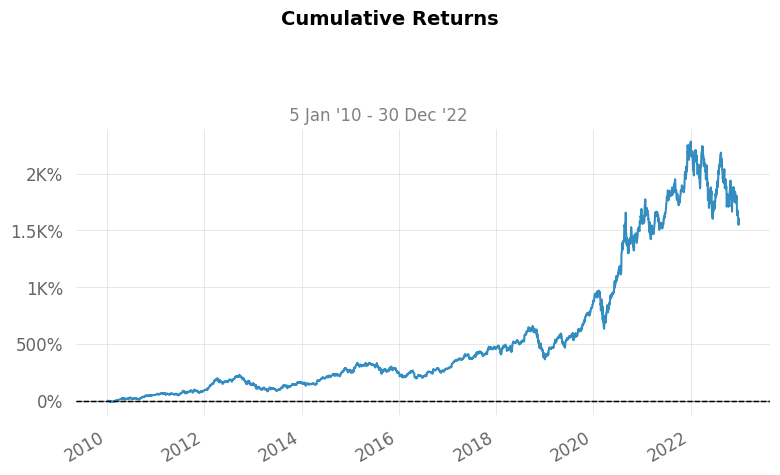

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


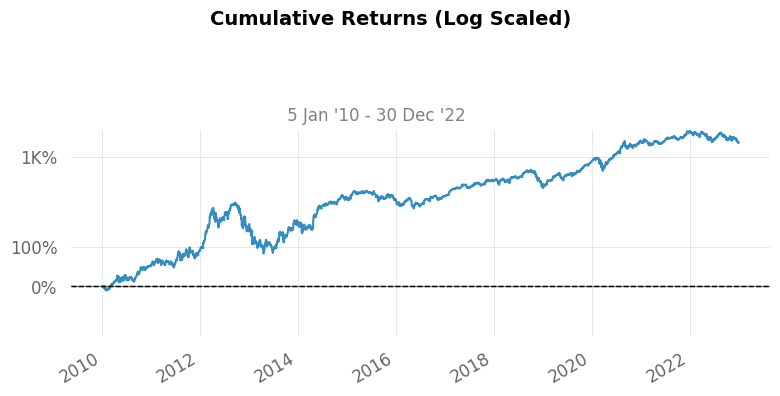

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


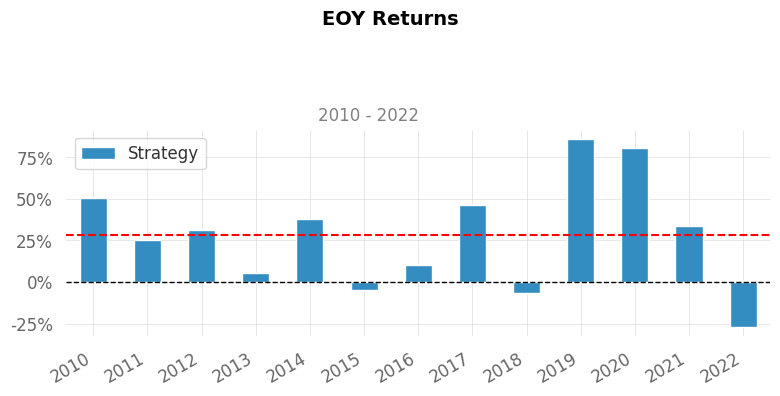

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


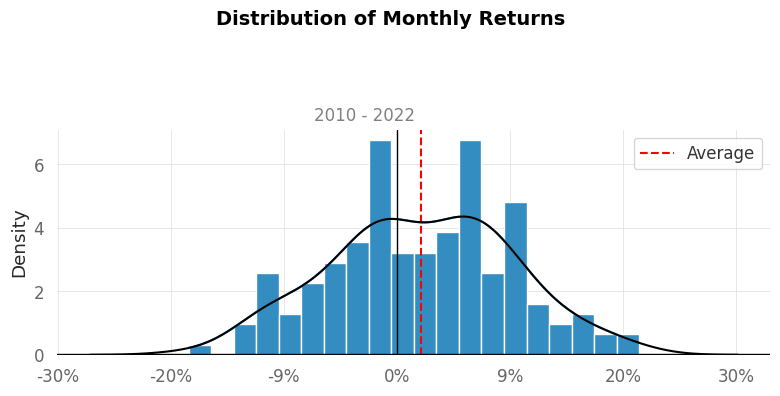

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


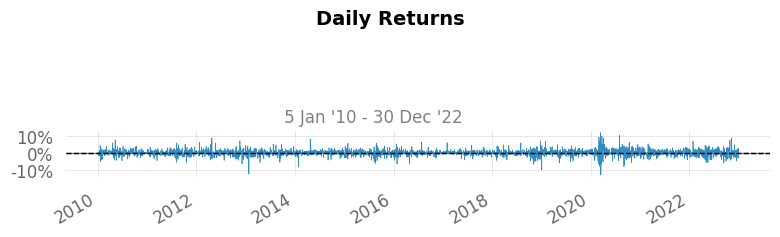

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


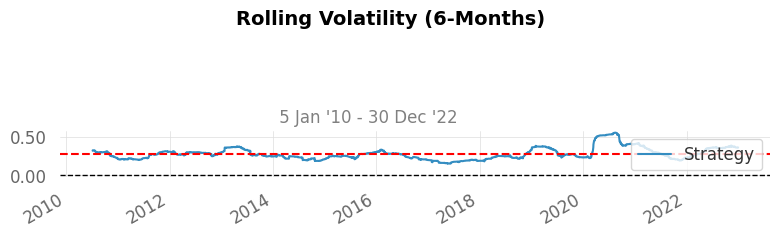

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


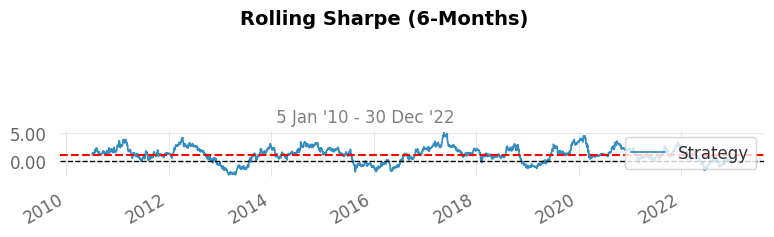

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


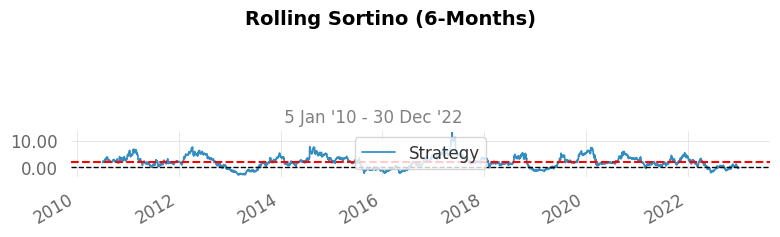

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


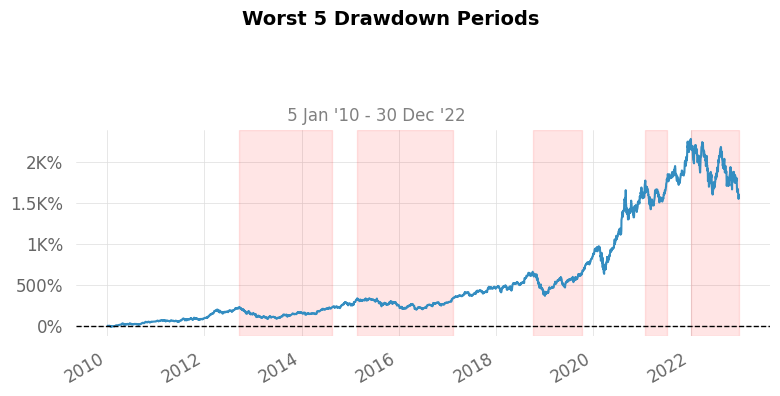

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


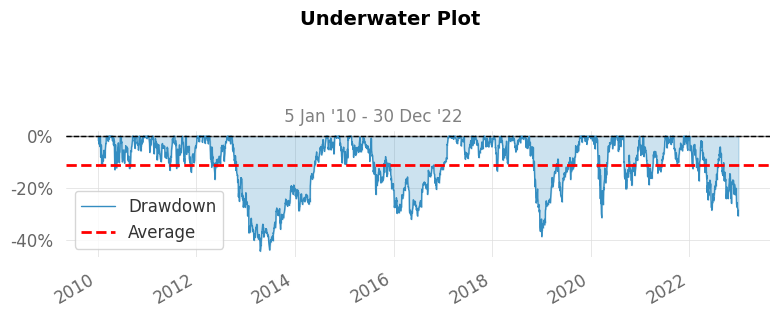

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


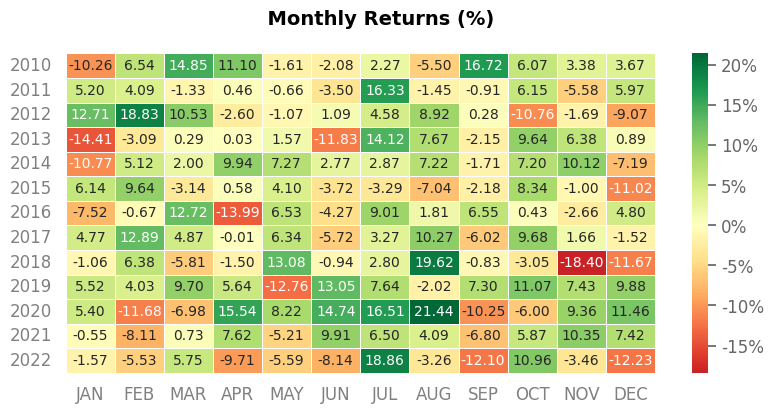

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


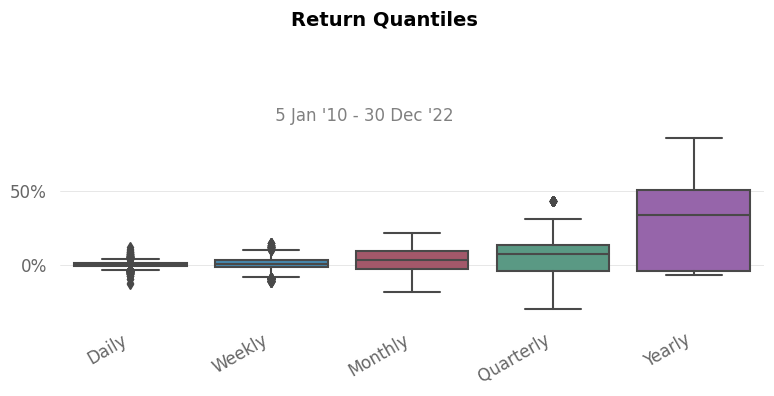

In [1]:
import yfinance as yf
import quantstats as qs
import pandas as pd
import numpy as np

# Download historical data from Yahoo Finance
ticker = "AAPL"  # Replace with the ticker symbol of the desired stock
data = yf.download(ticker, start="2010-01-01", end="2022-12-31")
returns = data['Close'].pct_change().dropna()

qs.reports.full(returns)